In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base
from feature_engineering.fe_xgb import generate_features

MODEL_NAME = "xgb_model"
PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-11-03 00:46:32.260552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-03 00:46:32.324497: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-03 00:46:32.737856: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_115


In [2]:
# 特徴生成
files = glob(f"{CFG['dataset']['step_csv_dir_10min']}/*.parquet")
train, features = generate_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [04:17<00:00,  1.08it/s]


,anglez,anglez_diff_abs,anglez_diff_abs_clip5,anglez_mean,enmo,enmo_diff_abs,enmo_mean,minutes,same_count,total_seconds,...,enmo_rolling_median_100_shift_1000,anglez_diff_abs_clip5_rolling_median_100_shift_1000,enmo_std_rolling_median_100_shift_1000,anglez_diff_abs_clip5_std_rolling_median_100_shift_1000,enmo_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_rolling_square_mean_100_shift_1000,enmo_std_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_std_rolling_square_mean_100_shift_1000,reduce_step,fold
926,21.070280,21.889490,4.451904,-20.794807,0.027129,0.014742,0.037067,477.5,0.0,68877.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22235,3
927,-2.156629,17.598087,3.993946,-21.465599,0.091583,0.079287,0.072814,597.5,0.0,68997.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22259,3
928,6.870979,16.874817,4.571238,-17.906569,0.048471,0.023354,0.085562,717.5,0.0,69117.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22283,3
929,11.430203,8.910088,3.756421,-5.006313,0.029496,0.013204,0.031394,837.5,0.0,69237.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22307,3
930,10.291650,2.129946,1.981583,-21.022831,0.003008,0.001954,0.058677,957.5,0.0,69357.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22331,3


(494843, 1307)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_xgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG[MODEL_NAME]["xgboost"], 
        es_rounds=200,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_{event}_fold_{i}.model'))
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)


with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.36308
[100]	eval-rmse:0.97641
[200]	eval-rmse:0.87793
[300]	eval-rmse:0.85110
[400]	eval-rmse:0.84264
[500]	eval-rmse:0.83884
[600]	eval-rmse:0.83737
[700]	eval-rmse:0.83638
[800]	eval-rmse:0.83562
[900]	eval-rmse:0.83517
[1000]	eval-rmse:0.83478
[1100]	eval-rmse:0.83422
[1200]	eval-rmse:0.83389
[1300]	eval-rmse:0.83370
[1400]	eval-rmse:0.83351
[1500]	eval-rmse:0.83344
[1600]	eval-rmse:0.83327
[1700]	eval-rmse:0.83316
[1800]	eval-rmse:0.83299
[1900]	eval-rmse:0.83290
[2000]	eval-rmse:0.83278
[2100]	eval-rmse:0.83260
[2200]	eval-rmse:0.83255
[2300]	eval-rmse:0.83253
[2400]	eval-rmse:0.83256
[2427]	eval-rmse:0.83256


 20%|██        | 1/5 [01:33<06:14, 93.61s/it]

== fold 1 ==
[0]	eval-rmse:1.43277
[100]	eval-rmse:1.04741
[200]	eval-rmse:0.95154
[300]	eval-rmse:0.92611
[400]	eval-rmse:0.91679
[500]	eval-rmse:0.91247
[600]	eval-rmse:0.91040
[700]	eval-rmse:0.90899
[800]	eval-rmse:0.90772
[900]	eval-rmse:0.90689
[1000]	eval-rmse:0.90612
[1100]	eval-rmse:0.90551
[1200]	eval-rmse:0.90512
[1300]	eval-rmse:0.90457
[1400]	eval-rmse:0.90416
[1500]	eval-rmse:0.90403
[1600]	eval-rmse:0.90368
[1700]	eval-rmse:0.90336
[1800]	eval-rmse:0.90285
[1900]	eval-rmse:0.90258
[2000]	eval-rmse:0.90229
[2100]	eval-rmse:0.90202
[2200]	eval-rmse:0.90190
[2300]	eval-rmse:0.90173
[2400]	eval-rmse:0.90167
[2500]	eval-rmse:0.90150
[2600]	eval-rmse:0.90136
[2700]	eval-rmse:0.90121
[2800]	eval-rmse:0.90112
[2900]	eval-rmse:0.90098
[3000]	eval-rmse:0.90086
[3100]	eval-rmse:0.90077
[3200]	eval-rmse:0.90052
[3300]	eval-rmse:0.90058
[3400]	eval-rmse:0.90051
[3500]	eval-rmse:0.90038
[3600]	eval-rmse:0.90022
[3700]	eval-rmse:0.90011
[3800]	eval-rmse:0.90011
[3900]	eval-rmse:0.90005

 40%|████      | 2/5 [04:03<06:19, 126.60s/it]

== fold 2 ==
[0]	eval-rmse:1.40630
[100]	eval-rmse:1.04342
[200]	eval-rmse:0.95184
[300]	eval-rmse:0.92774
[400]	eval-rmse:0.91930
[500]	eval-rmse:0.91585
[600]	eval-rmse:0.91414
[700]	eval-rmse:0.91285
[800]	eval-rmse:0.91190
[900]	eval-rmse:0.91120
[1000]	eval-rmse:0.91076
[1100]	eval-rmse:0.91053
[1200]	eval-rmse:0.91030
[1300]	eval-rmse:0.91013
[1400]	eval-rmse:0.91003
[1500]	eval-rmse:0.90983
[1600]	eval-rmse:0.90974
[1700]	eval-rmse:0.90969
[1800]	eval-rmse:0.90965
[1900]	eval-rmse:0.90957
[2000]	eval-rmse:0.90938
[2100]	eval-rmse:0.90931
[2200]	eval-rmse:0.90928
[2300]	eval-rmse:0.90912
[2400]	eval-rmse:0.90898
[2500]	eval-rmse:0.90896
[2600]	eval-rmse:0.90898
[2700]	eval-rmse:0.90895
[2800]	eval-rmse:0.90889
[2900]	eval-rmse:0.90877
[3000]	eval-rmse:0.90880
[3100]	eval-rmse:0.90874
[3112]	eval-rmse:0.90876


 60%|██████    | 3/5 [05:55<04:00, 120.20s/it]

== fold 3 ==
[0]	eval-rmse:1.37422
[100]	eval-rmse:0.98599
[200]	eval-rmse:0.88828
[300]	eval-rmse:0.86376
[400]	eval-rmse:0.85682
[500]	eval-rmse:0.85409
[600]	eval-rmse:0.85227
[700]	eval-rmse:0.85133
[800]	eval-rmse:0.85090
[900]	eval-rmse:0.85072
[1000]	eval-rmse:0.85032
[1100]	eval-rmse:0.85001
[1200]	eval-rmse:0.84981
[1300]	eval-rmse:0.84957
[1400]	eval-rmse:0.84948
[1500]	eval-rmse:0.84928
[1600]	eval-rmse:0.84917
[1700]	eval-rmse:0.84902
[1800]	eval-rmse:0.84891
[1900]	eval-rmse:0.84884
[2000]	eval-rmse:0.84884
[2100]	eval-rmse:0.84870
[2200]	eval-rmse:0.84877
[2300]	eval-rmse:0.84893
[2328]	eval-rmse:0.84891


 80%|████████  | 4/5 [07:23<01:47, 107.18s/it]

== fold 4 ==
[0]	eval-rmse:1.36382
[100]	eval-rmse:0.99144
[200]	eval-rmse:0.89939
[300]	eval-rmse:0.87569
[400]	eval-rmse:0.86746
[500]	eval-rmse:0.86414
[600]	eval-rmse:0.86252
[700]	eval-rmse:0.86176
[800]	eval-rmse:0.86128
[900]	eval-rmse:0.86090
[1000]	eval-rmse:0.86047
[1100]	eval-rmse:0.86039
[1200]	eval-rmse:0.86029
[1300]	eval-rmse:0.86008
[1400]	eval-rmse:0.86010
[1500]	eval-rmse:0.86013
[1546]	eval-rmse:0.86014


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.36497
[100]	eval-rmse:0.96814
[200]	eval-rmse:0.86754
[300]	eval-rmse:0.84028
[400]	eval-rmse:0.83088
[500]	eval-rmse:0.82694
[600]	eval-rmse:0.82491
[700]	eval-rmse:0.82391
[800]	eval-rmse:0.82311
[900]	eval-rmse:0.82253
[1000]	eval-rmse:0.82207
[1100]	eval-rmse:0.82167
[1200]	eval-rmse:0.82136
[1300]	eval-rmse:0.82115
[1400]	eval-rmse:0.82098
[1500]	eval-rmse:0.82099
[1600]	eval-rmse:0.82076
[1700]	eval-rmse:0.82066
[1800]	eval-rmse:0.82055
[1900]	eval-rmse:0.82056
[2000]	eval-rmse:0.82049
[2100]	eval-rmse:0.82045
[2200]	eval-rmse:0.82039
[2300]	eval-rmse:0.82049
[2376]	eval-rmse:0.82059


 20%|██        | 1/5 [01:25<05:42, 85.57s/it]

== fold 1 ==
[0]	eval-rmse:1.43012
[100]	eval-rmse:1.01877
[200]	eval-rmse:0.90816
[300]	eval-rmse:0.87664
[400]	eval-rmse:0.86424
[500]	eval-rmse:0.85829
[600]	eval-rmse:0.85545
[700]	eval-rmse:0.85415
[800]	eval-rmse:0.85311
[900]	eval-rmse:0.85232
[1000]	eval-rmse:0.85163
[1100]	eval-rmse:0.85099
[1200]	eval-rmse:0.85044
[1300]	eval-rmse:0.85016
[1400]	eval-rmse:0.84990
[1500]	eval-rmse:0.84968
[1600]	eval-rmse:0.84946
[1700]	eval-rmse:0.84922
[1800]	eval-rmse:0.84901
[1900]	eval-rmse:0.84865
[2000]	eval-rmse:0.84856
[2100]	eval-rmse:0.84834
[2200]	eval-rmse:0.84818
[2300]	eval-rmse:0.84817
[2400]	eval-rmse:0.84807
[2500]	eval-rmse:0.84813
[2600]	eval-rmse:0.84807
[2700]	eval-rmse:0.84816
[2781]	eval-rmse:0.84814


 40%|████      | 2/5 [03:07<04:46, 95.36s/it]

== fold 2 ==
[0]	eval-rmse:1.39970
[100]	eval-rmse:1.01715
[200]	eval-rmse:0.91818
[300]	eval-rmse:0.89165
[400]	eval-rmse:0.88107
[500]	eval-rmse:0.87705
[600]	eval-rmse:0.87519
[700]	eval-rmse:0.87412
[800]	eval-rmse:0.87358
[900]	eval-rmse:0.87312
[1000]	eval-rmse:0.87284
[1100]	eval-rmse:0.87266
[1200]	eval-rmse:0.87253
[1300]	eval-rmse:0.87237
[1400]	eval-rmse:0.87242
[1500]	eval-rmse:0.87245
[1505]	eval-rmse:0.87245


 60%|██████    | 3/5 [04:06<02:37, 78.78s/it]

== fold 3 ==
[0]	eval-rmse:1.37146
[100]	eval-rmse:0.99940
[200]	eval-rmse:0.91606
[300]	eval-rmse:0.89691
[400]	eval-rmse:0.89089
[500]	eval-rmse:0.88854
[600]	eval-rmse:0.88707
[700]	eval-rmse:0.88637
[800]	eval-rmse:0.88583
[900]	eval-rmse:0.88551
[1000]	eval-rmse:0.88511
[1100]	eval-rmse:0.88466
[1200]	eval-rmse:0.88432
[1300]	eval-rmse:0.88417
[1400]	eval-rmse:0.88401
[1500]	eval-rmse:0.88401
[1600]	eval-rmse:0.88396
[1700]	eval-rmse:0.88382
[1800]	eval-rmse:0.88372
[1900]	eval-rmse:0.88353
[2000]	eval-rmse:0.88348
[2100]	eval-rmse:0.88340
[2200]	eval-rmse:0.88341
[2300]	eval-rmse:0.88335
[2400]	eval-rmse:0.88334
[2500]	eval-rmse:0.88336
[2559]	eval-rmse:0.88341


 80%|████████  | 4/5 [05:39<01:24, 84.38s/it]

== fold 4 ==
[0]	eval-rmse:1.35901
[100]	eval-rmse:0.99446
[200]	eval-rmse:0.90749
[300]	eval-rmse:0.88552
[400]	eval-rmse:0.87795
[500]	eval-rmse:0.87474
[600]	eval-rmse:0.87241
[700]	eval-rmse:0.87130
[800]	eval-rmse:0.87028
[900]	eval-rmse:0.86979
[1000]	eval-rmse:0.86945
[1100]	eval-rmse:0.86903
[1200]	eval-rmse:0.86883
[1300]	eval-rmse:0.86863
[1400]	eval-rmse:0.86830
[1500]	eval-rmse:0.86802
[1600]	eval-rmse:0.86789
[1700]	eval-rmse:0.86784
[1800]	eval-rmse:0.86775
[1900]	eval-rmse:0.86772
[2000]	eval-rmse:0.86774
[2045]	eval-rmse:0.86774


100%|██████████| 5/5 [06:54<00:00, 82.96s/it]


## Dynamic-Range NMS

<AxesSubplot: >

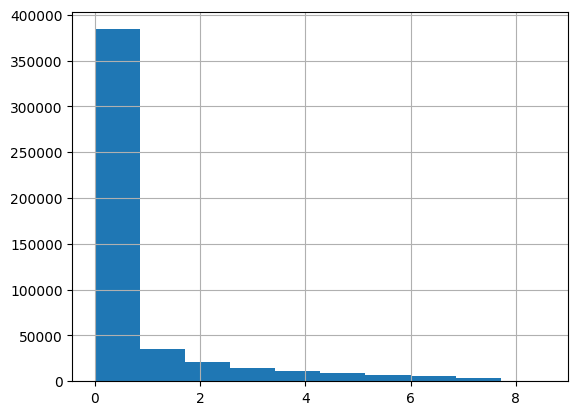

In [4]:
train = train[train["score"] > 0.005]
train["score"].hist()

In [5]:
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from tqdm import tqdm

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:05<00:00, 53.15it/s]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7774


event   tolerance
onset   12           0.248765
        36           0.681784
        60           0.781788
        90           0.826954
        120          0.843019
        150          0.856541
        180          0.864695
        240          0.878636
        300          0.883858
        360          0.889003
wakeup  12           0.201538
        36           0.697592
        60           0.788280
        90           0.827982
        120          0.850027
        150          0.863028
        180          0.872524
        240          0.886943
        300          0.896910
        360          0.907403
dtype: float64